# Global

In [1]:
global_var = {
    # Data
    'data_path': "/content/vessel_data",
    'prefix': "https://drive.google.com/uc?export=",
    'bifurcating_data_id': "download&id=1bzXusjOMgh-5hnw6RDNc03UUktQixtL4",
    'single_data_id': "download&id=19AHhDU1UWBzpG33wlB1r7b6sH3lMVly5",
    'guidance_id': "download&id=1cDI0Eh6hBpHQdE55-Ke0XSpUxcVu0SO9",
    'outer_id': "download&id=1nu_eI2SyN4zWRhIDJTsKxBW4b8eq6fPk",
    'current_name': "bifurcating",

    # Datasets
    'single_path': "./single/single.hdf5",
    'bifurcating_path': "./bifurcating/bifurcating.hdf5",
    'dataset_path': "./dataset.hdf5",
    'train_path': "./train.hdf5",
    'test_path': "./test.hdf5",
    # 'data_crop': 5466,
    'data_crop': 500,

    # Datasets quality check
    'data_length': 2000,
    'bases': 3,
    'data_keys': ['face', 'inlet_idcs', 'pos', 'pressure', 'wss'],

    # Geometric algebra
    'ga_dimension': 16,
    'grade_components': [1,4,6,4,1],

    # Train
    'train_test_split': 0.8,
    'validation_split': 0.1,
    'batch_size': 32,
    'num_workers': 2,
    'hidden_dim': 8,
    'num_heads': 4,
}

# Imports

In [2]:
!pip install einops wget pytorch_lightning torchvision --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 53.4 MB/s eta 0:00:00


In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import pytorch_lightning as pl
import pandas as pd
import re
import sys
import torch
import torch.nn as nn
import wget
import zipfile

from einops import rearrange
from IPython.display import HTML
from pytorch_lightning import LightningModule
from time import perf_counter
from torch.nn.functional import scaled_dot_product_attention
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

# Utils

## Data sanity check

In [4]:
def data_sanity_check(*input_data,output_data):
    """
    Check for NaN and Inf values in input and output data.

    Args:
        input_data (tensor): Input data.
        output_data (tensor): Output data.

    Returns:
        None: Prints logs indicating the presence of NaN or Inf values.
    """

    for data in input_data:
        input_nan = np.isnan(data.detach().numpy()).any()
        if input_nan:
            print("[LOG] \033[1mNan detected in input data\033[0m \u2718")
            return

        input_inf = np.isinf(data.detach().numpy()).any()
        if input_inf:
            print("[LOG] \033[1mInf detected in input data\033[0m \u2718")
            return

    output_nan = np.isnan(output_data.detach().numpy()).any()
    if output_nan:
        print("[LOG] \033[1mNan detected in output data\033[0m \u2718")
        return

    output_inf = np.isinf(output_data.detach().numpy()).any()
    if output_inf:
        print("[LOG] \033[1mInf detected in output data\033[0m \u2718")
        return

    print("[LOG] \033[1mData are free of infinite or Nan values\033[0m \u2714")

## Enable GPU

In [5]:
def device_setup():
    """
        Initialize GPU
    """
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print(f"[LOG] Currently working on \033[1m{device}\033[0m")
    return device

## Check device

In [6]:
def get_device(device):
  if device.type == "cpu":
    dev = !lscpu |grep 'Model name'
    dev = str(dev).strip("]'").split(":")[1].strip()
    print("Experiment runned throught Colab CPU:", dev)
    gpu = False

  else:
    dev = !nvidia-smi --query-gpu=gpu_name --format=csv
    print("Experiment runned throught Colab GPU:", dev[1])
    gpu = True

  return gpu

# Dataset

## Download datasets

In [7]:
def bar_progress(current,total,width = 80):
    """
        Simple bar to track the download list of links
        associated with patches in the dataset

        Args:
            current: current byte number
            total: total byte number
            width: visual length of the bar
    """
    progress = current / total * 100
    progress_string = f"{progress} % [{current} / {total}] bytes"
    name = global_var['current_name']
    description = f"[{name}] Recovering links: " + progress_string
    sys.stdout.write("\r" + description)
    sys.stdout.flush()

In [8]:
def get_links_list(list_link,dataset_name):
    """
        Download the file with the links referred to
        the dataset patches

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log

        Returns:
            links: list of the zipped dataset patches
    """
    global_var['current_name'] = dataset_name
    list_name = wget.download(list_link,bar = bar_progress)
    links = pkl.load(open(list_name, 'rb'))
    os.remove(list_name)
    os.makedirs(dataset_name, exist_ok = True)

    return links

In [9]:
def unzip_data_patches(links,dataset_name,debug):
    """
        Unzip the downloaded file patches to obtain the respective HDF5
        file within them, cleaning up excess files when finished

        Args:
            links: list with the links referred to file to download
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function

        Returns:
            hdf5_patches: list of HDF5 files
    """
    cnt = 0 if debug else None
    hdf5_patches = []

    tqdm_desc = f"[{dataset_name}] Downloading and unzipping data patches"
    for link in tqdm(links,desc = tqdm_desc):
        name = wget.download(link)
        with zipfile.ZipFile(name, 'r') as zip_ref:
            zip_ref.extractall("/content/")
            hdf5_patches.append(name.replace(".zip",".hdf5"))
            os.remove(name)
            if debug:
                cnt +=1
            if debug and cnt > 3:
                break
    return hdf5_patches

In [10]:
def compose_dataset(dataset_file,dataset_name,hdf5_patches):
    """
        Merge several HDF5 files into one,

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name
            hdf5_patches: list of file to merge
    """
    with h5py.File(dataset_file, 'w') as file_dest:
        tqdm_desc = f"[{dataset_name}] Composing HDF5 full dataset"
        for file_origine in tqdm(hdf5_patches,desc = tqdm_desc):
            percorso_file_origine = os.path.join("/content/", file_origine)

            with h5py.File(percorso_file_origine, 'r') as file_orig:
                for gruppo_nome, gruppo in file_orig.items():
                    gruppo_dest = file_dest.create_group(gruppo_nome)

                    for data_name, dataset in gruppo.items():
                        gruppo_dest.create_dataset(data_name, data=dataset[()])

    for file in hdf5_patches:
        percorso_file = os.path.join("/content/", file)
        os.remove(percorso_file)

In [11]:
def quality_check(dataset_file,dataset_name):
    """
        Check that the final dataset meets the standards

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name used for log

        Returns:
            (Boolean): logical result of the check
    """
    print(f"[{dataset_name}]\033[1m Dataset quality check \033[0m")

    with h5py.File(dataset_file, 'r') as dataset:
        # Check correct length
        len_condition = (len(dataset) == global_var['data_length'])
        if len_condition:
            error_str = "All samples present in the dataset \u2714"
            print(f"[{dataset_name}] " + error_str)
        else:
            missing_samples = global_var['data_length'] - len(dataset)
            error_str = "Not all samples are in the dataset \u2718"
            print(f"[{dataset_name}] " + error_str)
            if missing_samples > 1:
                print(f"[{dataset_name}] \t -> {missing_samples} is missing")
            else:
                print(f"[{dataset_name}] \t -> {missing_samples} are missing")
            return False

        # Check correct keys
        keys_condition = True
        for sample in list(dataset.keys()):
            correct_keys = list(dataset[sample].keys())
            current_keys = global_var['data_keys']
            keys_condition = keys_condition and (correct_keys == current_keys)
            if not keys_condition:
                problematic_sample = sample
                break
        if keys_condition:
            print(f"[{dataset_name}] All samples keys are correct \u2714")
        else:
            print(f"[{dataset_name}] Error in samples keys \u2718")
            print(f"[{dataset_name}] \t -> Check {problematic_sample}")
            return False

        # Check correct ordering
        ordering_condition = True
        numbers = [re.search(r'_\d+', s).group()[1:] for s in dataset.keys()]
        for n in range(len(numbers)):
            counter = f'{n:04d}'
            ordering_condition = ordering_condition and (numbers[n] == counter)
            if numbers[n] != counter:
                problematic_sample = counter
            break

        if ordering_condition:
            print(f"[{dataset_name}] Samples are ordered \u2714")
        else:
            print(f"[{dataset_name}] Samples are NOT ordered \u2718")
            print(f"[{dataset_name}] \t -> Check {counter}")
            return False

    return True

In [12]:
def download_dataset(list_link, dataset_name, debug):
    """
        Download the dataset divided into several patches,
        assemble it and check that the operation is successful

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function
    """
    dataset_file = dataset_name + "/" + dataset_name + ".hdf5"
    if not os.path.exists(dataset_name):
        links = get_links_list(list_link,dataset_name)
        hdf5_patches = unzip_data_patches(links,dataset_name,debug)
        compose_dataset(dataset_file,dataset_name,hdf5_patches)
        check = quality_check(dataset_file,dataset_name)

        if check:
            success_string = "Dataset correctly downloaded \033[0m\u2714"
            print(f"[{dataset_name}] \u2714\033[1m " + success_string)
        else:
            error_string = "Dataset download failed \033[0m\u2718"
            print(f"[{dataset_name}] \u2718\033[1m " + error_string)
    else:
        done_string = f"Dataset is already available in {dataset_file}"
        print(f"[{dataset_name}] " + done_string)

In [13]:
bifurcating_link = global_var['prefix'] + global_var["bifurcating_data_id"]
download_dataset(
    list_link = bifurcating_link,
    dataset_name = "bifurcating",
    debug = False
)

[bifurcating] Recovering links: 100.0 % [8708 / 8708] bytes

[bifurcating] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Dataset quality check 
[bifurcating] All samples present in the dataset ✔
[bifurcating] All samples keys are correct ✔
[bifurcating] Samples are ordered ✔
[bifurcating] ✔ Dataset correctly downloaded ✔


In [14]:
single_link = global_var['prefix'] + global_var["single_data_id"]
download_dataset(
    list_link = single_link,
    dataset_name = "single",
    debug = False
)

[single] Recovering links: 100.0 % [8708 / 8708] bytes

[single] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Dataset quality check 
[single] All samples present in the dataset ✔
[single] All samples keys are correct ✔
[single] Samples are ordered ✔
[single] ✔ Dataset correctly downloaded ✔


## Train and test data

In [15]:
def copy_data(source, destination, new_sample, old_sample, label):
    """
    Copy data from a source HDF5 group to a destination HDF5 group.

    Args:
        source (h5py.Group): Source HDF5 group.
        destination (h5py.Group): Destination HDF5 group.
        new_sample (str): Name of the new sample in the destination group.
        old_sample (str): Name of the old sample in the source group.
        label: Label for the new sample.

    Returns:
        None: Copies data and creates a new sample in the destination group.
    """
    destination.create_group(new_sample)
    for field in list(source[old_sample].keys()):
        new_field_data = source[old_sample][field][()]
        destination[new_sample].create_dataset(field, data = new_field_data)

    destination[new_sample].create_dataset('label', data = np.array([label]))

In [16]:
def shuffle_dataset(temp_dataset,dataset):
    """
    Shuffle the samples in a dataset and create a new shuffled HDF5 file.

    Args:
        temp_dataset (str): Path to the temporary HDF5 file.
        dataset (str): Path to the destination HDF5 file.

    Returns:
        None: Creates a new shuffled HDF5 file and removes the temporary file.
    """
    with h5py.File(temp_dataset, 'r') as file:
        # Extract group names (assuming they are 'sample_0000', etc.)
        sample_names = list(file.keys())

        # Shuffle indices
        shuffled_indices = np.random.permutation(len(sample_names))

        # Create a new shuffled HDF5 file
        with h5py.File(dataset, 'w') as shuffled_file:
            values = enumerate(shuffled_indices)
            iters = len(shuffled_indices)
            shuffle_desc = '[LOG] Shuffling dataset'

            for new_index, old_index in tqdm(
                values,
                total = iters,
                desc = shuffle_desc
            ):
                sample = f'sample_{new_index:04d}'
                old_name = f'sample_{old_index:04d}'
                shuffled_file.create_group(sample)
                for field in file[old_name]:
                    shuffled_file[sample][field] = file[old_name][field][()]

    os.remove(temp_dataset)

In [17]:
def train_test_split(dataset):
    """
    Split the dataset into training and test sets and create new HDF5 files.

    Args:
        dataset (str): Path to the original HDF5 file.

    Returns:
        None: Creates new HDF5 files for the training and test sets, and removes the original file.
    """
    with h5py.File(dataset, 'r') as file:
        total_rows = len(file)

        # Calculates the number of rows for each set
        train_rows = int(global_var['train_test_split'] * total_rows)
        test_rows = total_rows - train_rows

        if not os.path.exists(global_var['train_path']):
            # Create a new HDF5 file for the training set
            with h5py.File(global_var['train_path'], 'w') as train_file:
                iters = range(train_rows)
                train_desc = "[LOG] Composing train set"

                for i in tqdm(iters,desc = train_desc):
                    sample = f'sample_{i:04d}'
                    train_file.create_group(sample)

                    for field in file['sample_0000']:
                        train_file[sample][field] = file[sample][field][()]

        if not os.path.exists(global_var['test_path']):
            # Create a new HDF5 file for the test set
            with h5py.File(global_var['test_path'], 'w') as test_file:
                iters = range(train_rows, total_rows)
                test_desc = "[LOG] Composing test set"

                for i in tqdm(iters,desc = test_desc):
                    sample = f'sample_{i:04d}'
                    test_file.create_group(f'sample_{i:04d}')

                    for field in file['sample_0000']:
                        sample = f'sample_{i:04d}'
                        test_file[sample][field] = file[sample][field][()]

    os.remove(dataset)

In [18]:
def merge_datasets(single_path,bifurcating_path,debug = False):
    """
    Merge single and bifurcating datasets, copy data, shuffle, and split into train and test sets.

    Args:
        single_path (str): Path to the single dataset.
        bifurcating_path (str): Path to the bifurcating dataset.
        debug (bool): Debug mode flag.

    Returns:
        None: Merges datasets, copies data, shuffles, and splits into train and test sets.
    """
    train_condition = os.path.exists(global_var['train_path'])
    test_condition = os.path.exists(global_var['test_path'])
    start_condition =  train_condition and test_condition

    if debug or not start_condition:
        with h5py.File(single_path, 'r') as single, \
            h5py.File(bifurcating_path, 'r') as bifurcating:
            signle_len = range(len(single))
            bifurcating_len = range(len(bifurcating))

            dataset_path = global_var['dataset_path']
            temp_dataset = dataset_path.replace(".hdf5", "_temp.hdf5")
            with h5py.File(temp_dataset, 'w') as dataset:
                single_desc = "[single] Copying data"
                for single_idx in tqdm(signle_len, desc = single_desc):
                    sample_name = f'sample_{single_idx:04d}'
                    label = 0
                    copy_data(
                        source = single,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = sample_name,
                        label = label
                     )

                bifurcating_desc = "[bifurcating] Copying data"
                for bif_idx in tqdm(bifurcating_len, desc = bifurcating_desc):
                    sample_name = f'sample_{bif_idx + 2000:04d}'
                    old_sample_name = f'sample_{bif_idx:04d}'
                    label = 1
                    copy_data(
                        source = bifurcating,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = old_sample_name,
                        label = label
                     )

        shuffle_dataset(temp_dataset,global_var['dataset_path'])
        train_test_split(global_var['dataset_path'])
    else:
        print("[LOG] Train and test sets already available")

In [19]:
merge_datasets(
    single_path = global_var['single_path'],
    bifurcating_path = global_var['bifurcating_path'],
    debug = True
)

[single] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[bifurcating] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[LOG] Shuffling dataset:   0%|          | 0/4000 [00:00<?, ?it/s]

[LOG] Composing train set:   0%|          | 0/3200 [00:00<?, ?it/s]

[LOG] Composing test set:   0%|          | 0/800 [00:00<?, ?it/s]

# EDA

## Data statistics

In [ ]:
def data_statistics(file_path):
    """
    Display descriptive statistics for various properties in the dataset.

    Args:
        file_path (str): Path to the HDF5 file.

    Returns:
        None: Displays the descriptive statistics.
    """
    with h5py.File('train.hdf5', 'r') as file:
        wss_values = file['sample_0000']['wss'][:]
        pressure_values = file['sample_0000']['pressure'][:]
        position_values = file['sample_0000']['pos'][:]
        faces_values = file['sample_0000']['face'][:]
        inlet_idcs_values = file['sample_0000']['inlet_idcs'][:]

    df_pressure = pd.DataFrame(
        pressure_values * 1e-3,
        columns = ['Pressure']
    ).describe()

    df_wss = pd.DataFrame(
        wss_values,
        columns = ['WSS_x', 'WSS_y', 'WSS_z']
    ).describe()

    df_position = pd.DataFrame(
        position_values,
        columns = ['Position_x', 'Position_y', 'Position_z']
    ).describe()

    df_face = pd.DataFrame(
        faces_values,
        columns = ['Face_x', 'Face_y', 'Face_z']
    ).describe()

    df_inlet = pd.DataFrame(
        inlet_idcs_values,
        columns = ['Inlet']
    ).describe()

    df = pd.concat([
        df_pressure,
        df_wss,
        df_position,
        df_face,
        df_inlet
    ],axis = 1)

    df.iloc[1:] = df.iloc[1:].applymap('{:.4f}'.format)
    display(df)

In [ ]:
data_statistics(global_var['train_path'])

,Pressure,WSS_x,WSS_y,WSS_z,Position_x,Position_y,Position_z,Face_x,Face_y,Face_z,Inlet
count,17009.0,17009.0,17009.0,17009.0,17009.0,17009.0,17009.0,34014.0,34014.0,34014.0,839.0
mean,133.5755,-2.6206,-1.3266,8.2399,-0.1609,-0.1246,1.0904,7211.8458,10907.5239,7300.7027,15491.7855
std,0.1350,2.4508,3.7690,9.3095,0.1716,0.2732,0.6965,4803.9653,4135.8473,4820.3767,2642.1134
min,133.3484,-27.3796,-42.7011,-20.0451,-0.5651,-0.8972,-0.0081,0.0000,0.0000,0.0000,488.0000
25%,133.4617,-3.9624,-1.2553,0.0000,-0.2777,-0.1821,0.5366,3111.0000,8118.2500,3219.0000,15807.5000
50%,133.5799,-2.3114,-0.3205,11.5657,-0.1747,-0.0713,1.0005,6538.0000,11817.5000,6630.0000,16247.0000
75%,133.6907,-0.9551,0.0976,14.6337,-0.0404,0.0861,1.6620,10756.0000,14290.0000,10874.7500,16633.5000
max,133.8446,13.5171,20.8096,49.0404,0.2028,0.1983,2.4024,17008.0000,17008.0000,17008.0000,17006.0000


## Data shapes

In [ ]:
def data_shapes():
    """
    Collect and display shape statistics for various properties in the dataset.

    Returns:
        None: Displays the shape statistics.
    """
    with h5py.File("train.hdf5") as data:
        pos = []
        face = []
        wss = []
        inlet = []
        pressure = []

        stats_desc = "Collecting shape statistics"
        for sample in tqdm(list(data.keys()),desc = stats_desc):
            pos.append(data[sample]['pos'].shape[0])
            face.append(data[sample]['face'].shape[0])
            wss.append(data[sample]['wss'].shape[0])
            inlet.append(data[sample]['inlet_idcs'].shape[0])
            pressure.append(data[sample]['pressure'].shape[0])

    pos = np.array(pos)
    face = np.array(face)
    wss = np.array(wss)
    inlet = np.array(inlet)
    pressure = np.array(pressure)

    stats = {
        'Position': pos,
        'Faces':face,
        'WSS':wss,
        'Inlet':inlet,
        'Pressure':pressure
     }

    df = pd.DataFrame(stats)

    result_df = pd.DataFrame({
        'Mean': df.mean().astype(int),
        'Max': df.max(),
        'Min': df.min()
    })

    display(result_df)

In [ ]:
data_shapes()

,Mean,Max,Min
Position,13047,24800,5466
Faces,26091,49596,10928
WSS,13047,24800,5466
Inlet,539,1659,143
Pressure,13047,24800,5466


## Dataset balancing

In [ ]:
def read_labels(file_path):
    """
    Read and count labels from the dataset.

    Args:
        file_path (str): Path to the HDF5 file.

    Returns:
        tuple: Number of single and bifurcating labels.
    """
    labels = []

    with h5py.File(file_path, 'r') as file:
        for sample in tqdm(list(file.keys()),desc = "Check label balancing"):
            labels.append(file[sample]['label'][0])

    single_labels = labels.count(0)
    bifurcating_labels = labels.count(1)

    return single_labels,bifurcating_labels

In [ ]:
def autolabel(ax,bars):
    """
    Attach a text label above each bar displaying its height.

    Args:
        ax (matplotlib.axes.Axes): The axes on which the bars are plotted.
        bars (list): List of bar objects.
    """
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            '{}'.format(height),
            xy = (bar.get_x() + bar.get_width() / 2, height),
            xytext = (0, 4),
            textcoords = "offset points",
            ha = 'center',
            va = 'bottom',
            weight = 'bold',
            size = 12
         )

In [ ]:
def check_label_balance(train_file_path):
    """
    Plot a bar chart to visualize the balance of labels in the training set.

    Args:
        train_file_path (str): HDF5 file path containing the training set.
    """
    labels = read_labels(train_file_path)
    categories = ['Single', 'Bifurcating']

    color_0 = (0.0, 0.4, 1.0)
    color_1 = (1.0, 0.6, 0.0)
    bar_width = 0.8

    fig, ax = plt.subplots(figsize = (8,5))

    bars = ax.bar(
        categories,
        labels,
        color = [color_0, color_1],
        width = bar_width,
        align = 'center'
     )

    ax.set_xlabel('Label')
    ax.set_ylabel('Occurence')
    ax.set_title('Counting Labels in the train set', weight = 'bold')

    autolabel(ax,bars)

    plt.ylim(ymax = max(labels) + 200)
    plt.show()

Check label balancing:   0%|          | 0/3200 [00:00<?, ?it/s]

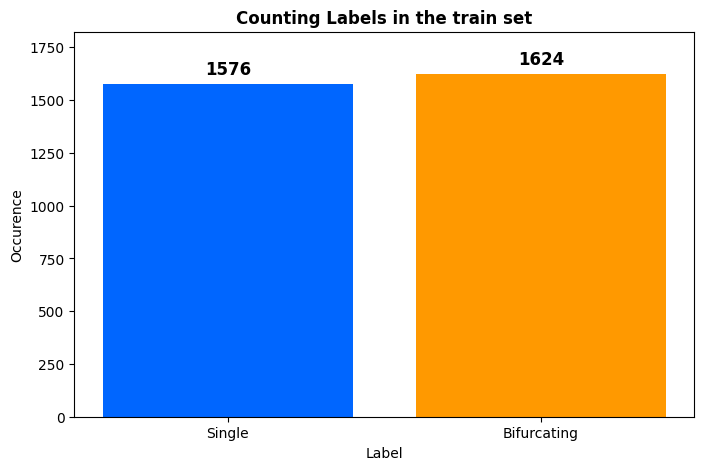

In [ ]:
check_label_balance(global_var['train_path'])

## Scatter plot

In [ ]:
def get_scatter_data(file_path):
    """
    Get scatter data for pressures and WSS.

    Args:
        file_path (str): Path to the HDF5 file.

    Returns:
        tuple: Lists of pressures and WSS for single and bifurcating samples.
    """
    single_pressures = []
    single_wss = []
    bifurcating_pressures = []
    bifurcating_wss = []

    with h5py.File(file_path, 'r') as file:
        for sample in tqdm(list(file.keys()),desc = "Getting scatter data"):
            # Shift to mPa (millPascal)
            pressure = file[sample]['pressure'][()]
            mean_pressure = np.array(pressure).mean() * 1e-3
            mean_wss = np.array(file[sample]['wss'][()]).mean()

            if file[sample]['label'][0] == 0:
                single_pressures.append(mean_pressure)
                single_wss.append(mean_wss)
            else:
                bifurcating_pressures.append(mean_pressure)
                bifurcating_wss.append(mean_wss)

    pressures = [single_pressures,bifurcating_pressures]
    wss = [single_wss,bifurcating_wss]

    return pressures,wss

In [ ]:
def scatter_plot(file_path):
    """
    Create a scatter plot between mean WSS and Pressure
    for single and bifurcating samples.

    Args:
        file_path (str): Path to the HDF5 file.
    """
    pressures,wss = get_scatter_data(file_path)

    fig, ax = plt.subplots(figsize = (10,7))

    ax.scatter(
        pressures[0],
        wss[0],
        label = 'Single',
        alpha = 0.3
     )
    ax.scatter(
        pressures[1],
        wss[1],
        label = 'Bifurcating',
        alpha = 0.3
     )

    ax.set_xlabel('Mean Pressure')
    ax.set_ylabel('Mean WSS (Wall Shear Stress)')
    ax.set_title('Scatterplot between mean WSS e Pressure', weight = 'bold')

    ax.legend()
    plt.show()

Getting scatter data:   0%|          | 0/3200 [00:00<?, ?it/s]

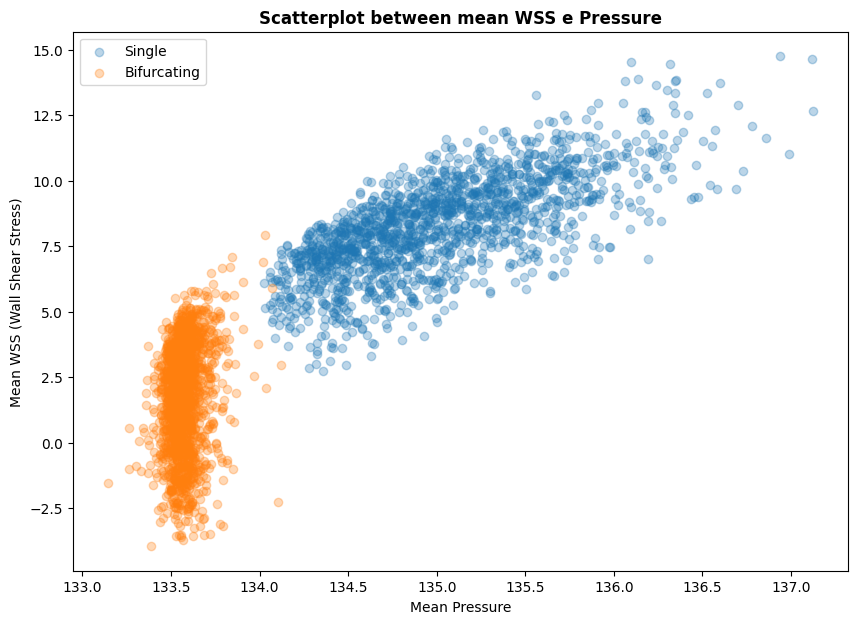

In [ ]:
scatter_plot(global_var['train_path'])

# Geometric Algebra

## Embedding in geometric algebra

In [20]:
def get_pos_mv(pos):
    """
    Embed the (n_items,3) position vector in geometric algebra

    Args:
        pos (torch.Tensor): Input position tensor.

    Returns:
        torch.Tensor: Embed of the position vector in geometric algebra
    """
    n_items, dimension = pos.shape
    reshaped_pos = pos.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_pos.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 14] = 1 # homogeneous coordinates
    mv[..., 11] = reshaped_pos[..., 0] # x-coordinate of pos
    mv[..., 12] = reshaped_pos[..., 1] # y-coordinate of pos
    mv[..., 13] = reshaped_pos[..., 2] # z-coordinate of pos

    return mv

In [21]:
def get_face_mv(face):
    """
    Embed the (n_items,3) faces vector in geometric algebra

    Args:
        face (torch.Tensor): Input faces tensor.

    Returns:
        torch.Tensor: Embed of the faces vector in geometric algebra
    """
    n_items, dimension = face.shape
    reshaped_face = face.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_face.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 2] = reshaped_face[..., 0]
    mv[..., 3] = reshaped_face[..., 1]
    mv[..., 4] = reshaped_face[..., 2]

    return mv

In [22]:
def get_wss_mv(wss):
    """
    Embed the (n_items,3) wss vector in geometric algebra

    Args:
        pos (torch.Tensor): Input wss tensor.

    Returns:
        torch.Tensor: Embed of the wss vector in geometric algebra
    """
    n_items, dimension = wss.shape
    reshaped_wss = wss.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_wss.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 0] = 1 # homogeneous coordinates

    mv[..., 5] = 0.5 * reshaped_wss[..., 0]
    mv[..., 6] = 0.5 * reshaped_wss[..., 1]
    mv[..., 7] = 0.5 * reshaped_wss[..., 2]

    return mv

In [23]:
def get_inlet_mv(inlet):
    """
    Embed the (n_items,) inlet vector in geometric algebra

    Args:
        pos (torch.Tensor): Input inlet tensor.

    Returns:
        torch.Tensor: Embed of the inlet vector in geometric algebra
    """
    n_items = inlet.shape[0]
    reshaped_inlet = inlet.reshape(1,n_items,1,1)

    mv_shape = reshaped_inlet.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 0] = reshaped_inlet[...,0]

    return mv

In [24]:
def get_pressure_mv(pressure):
    """
    Embed the (n_items,) pressures vector in geometric algebra

    Args:
        pos (torch.Tensor): Input pressures tensor.

    Returns:
        torch.Tensor: Embed of the pressures vector in geometric algebra
    """
    n_items = pressure.shape[0]
    reshaped_pressure = pressure.reshape(1,n_items,1,1)

    mv_shape = reshaped_pressure.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 0] = reshaped_pressure[...,0]

    return mv

In [25]:
def embed_data(sample):
    """
    Embed data properties into a multivector

    Args:
        sample (dict): Dataset sample

    Returns:
        torch.Tensor: Sample proprietries embedded in geometric
                        algebra via multivector
    """
    # 'pos' property modeled as a point
    cropped_pos = sample['pos'][:global_var['data_crop']]
    input_pos = torch.tensor(np.array(cropped_pos))
    pos_mv = get_pos_mv(input_pos)

    # 'face' property modeled as a plane
    cropped_face = sample['face'][:global_var['data_crop']]
    input_face = torch.tensor(np.array(cropped_face))
    face_mv = get_face_mv(input_face)

    # 'wss' property modeled as a translation
    cropped_wss = sample['wss'][:global_var['data_crop']]
    input_wss = torch.tensor(np.array(cropped_wss))
    wss_mv = get_wss_mv(input_wss)

    # 'pressure' modeled as a scalar
    cropped_pressure = sample['pressure'][:global_var['data_crop']]
    input_pressure = torch.tensor(np.array(cropped_pressure))
    pressure_mv = get_pressure_mv(input_pressure)

    # (batch,n_items,sample_features,ga_dimension)
    total_mvs = torch.cat([pos_mv, face_mv, wss_mv, pressure_mv],dim = 2)

    return total_mvs

## Blade

In [26]:
def blade_operator():
    mv_dimension = global_var['ga_dimension']
    blade_shape = (mv_dimension,mv_dimension)

    coordinates = []
    start = 0
    for length in global_var['grade_components']:
        coordinates.append(list(range(start, start + length)))
        start += length

    coord_permutations = [
        [[0,1]],
        [[2,5],[3,6],[4,7]],
        [[8,11],[9,12],[10,13]],
        [[14,15]]
     ]
    blade_mask = []

    w_dimension = len(global_var['grade_components'])
    for k_grade in range(w_dimension):
        w_blade = torch.zeros(blade_shape)
        for coordinate in coordinates[k_grade]:
            w_blade[coordinate, coordinate] = 1.0
        blade_mask.append(w_blade.unsqueeze(0))

    v_dimension = len(global_var['grade_components']) - 1
    for k_grade in range(v_dimension):
        v_blade = torch.zeros(blade_shape)
        for coord_to,coord_from in coord_permutations[k_grade]:
            v_blade[coord_from, coord_to] = 1.0
        blade_mask.append(v_blade.unsqueeze(0))

    blade_operator = torch.cat(blade_mask,dim = 0)

    return blade_operator

In [27]:
# Show the effect of the blade on mv
blade = blade_operator()
sample = h5py.File("train.hdf5", 'r')["sample_0000"]
wss_mv = embed_data(sample)[0][0][0]

print("[LOG] Initial multivector for Position: \n\t",end = "")
initial_mv = []
for wss in wss_mv:
    wss = round(wss.item(),4)
    initial_mv.append(wss)
print(initial_mv)

bladed_input = blade * wss_mv
blade_w_range = len(global_var['grade_components'])
bladed_mv = []
for blade_w in range(blade_w_range):
    bladed_mv_w = []
    for coord in range(global_var['ga_dimension']):
        blade_elem = bladed_input[blade_w,coord,coord].item()
        rounded_blade = round(blade_elem,4)
        bladed_mv_w.append(rounded_blade)
    bladed_mv.append(bladed_mv_w)

coord_permutations = [
        [[0,1]],
        [[2,5],[3,6],[4,7]],
        [[8,11],[9,12],[10,13]],
        [[14,15]]
     ]

blade_v_range = bladed_input.shape[0]
for blade_v in range(blade_w,blade_v_range):
    bladed_mv_v = []
    for coord in range(global_var['ga_dimension']):
        if coord == 0:
            x = coord_permutations[0][0][1]
            y = coord_permutations[0][0][0]
        if coord >= 2 and coord <= 4:
            x = coord_permutations[1][1]
            y = coord_permutations[1][0]
        if coord >= 8 and coord <= 10:
            x = coord_permutations[2][1]
            y = coord_permutations[2][0]
        if coord == 14:
            x = coord_permutations[3][0][1]
            y = coord_permutations[3][0][0]
        else:
            x = coord
            y = coord

        blade_elem = bladed_input[blade_v,x,y].item()
        rounded_blade = round(blade_elem,4)
        bladed_mv_v.append(rounded_blade)
    bladed_mv.append(bladed_mv_v)

for blade_idx in range(len(bladed_mv)):
    bladed_output = bladed_mv[blade_idx]
    if not all(x == 0 for x in bladed_output):
        if blade_idx < 5:
            log_str = f"[LOG] Blade w grade {blade_idx}: \n\t"
            print(log_str,end = "")
        else:
            log_str = f"[LOG] Blade v grade {blade_idx - blade_w_range - 1}: \n\t"
            print(log_str,end = "")
        print(bladed_output)

[LOG] Initial multivector for Position: 
	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.1233, -0.2652, -0.1134, 1.0, 0.0]
[LOG] Blade w grade 3: 
	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.1233, -0.2652, -0.1134, 1.0, 0.0]
[LOG] Blade v grade 3: 
	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 1.0, 0.0]


## Reverse

In [28]:
def get_coordinates_range():
    grade_components = global_var['grade_components']
    coordinates_range = []

    for grade in range(len(grade_components)):
        start_idx = sum(grade_components[:grade])
        end_idx = sum(grade_components[:grade + 1]) - 1
        coordinate_range = [start_idx,end_idx]
        coordinates_range.append(coordinate_range)

    return coordinates_range

In [29]:
def reverse_operator():
    reverse_operator = torch.ones(16)
    *_, bivector_range, trivector_range, _ = get_coordinates_range()

    reverse_range = list(
        range(
            bivector_range[0],
            trivector_range[-1] + 1
        )
    )

    reverse_operator[reverse_range] = -1

    return reverse_operator

## Dual

In [30]:
def dual_operators():
    coords_range = get_coordinates_range()

    dual_sign_idxs = [2,4,6,9,12,14]
    dual_signs = [1 if i not in dual_sign_idxs else -1 for i in range(global_var['ga_dimension'])][::-1]
    dual_signs = torch.tensor(dual_signs)

    dual_flip = list(range(coords_range[-1][0],coords_range[0][0]-1,-1))

    return dual_flip, dual_signs

## Geometric product

In [31]:
def get_guidance_matrix():
    if not os.path.exists("guidance_matrix.pt"):
        matrix_url = global_var['prefix'] + global_var['guidance_id']
        matrix_file = wget.download(matrix_url)

    guidance_matrix = product_basis = torch.load("guidance_matrix.pt")
    guidance_matrix = guidance_matrix.to(torch.float32)
    guidance_matrix = guidance_matrix.to_dense()

    return guidance_matrix

In [32]:
def geometric_product(x,y):
    guidance_matrix = get_guidance_matrix()

    geom_prod = torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance_matrix,
        x,
        y
    )

    return geom_prod

## Inner product

In [33]:
def inner_product(x,y):
    dual_x = reverse_operator() * x
    geom_x_y = geometric_product(dual_x,y)
    inner_product = geom_x_y[..., [0]]

    return inner_product

In [34]:
def faster_inner_product(x,y):
    guidance_matrix = get_guidance_matrix()
    reverse_op = reverse_operator()

    inner_product_mask = (torch.diag(guidance_matrix[0]) * reverse_op).bool()

    x = x[..., inner_product_mask]
    y = y[..., inner_product_mask]

    # questo è un "geom prod2 modificato"
    inner_product = torch.einsum(
        "... i, ... i -> ...", x, y
    ).unsqueeze(-1)


    return inner_product

## Outer product

In [35]:
def get_outer_matrix():
    if not os.path.exists("outer_guidance.pt"):
        matrix_url = global_var['prefix'] + global_var['outer_id']
        matrix_file = wget.download(matrix_url)

    outer_matrix = product_basis = torch.load("outer_guidance.pt")
    outer_matrix = outer_matrix.to(torch.float32)
    outer_matrix = outer_matrix.to_dense()

    return outer_matrix

In [36]:
def outer_product(x,y):
    outer_matrix = get_outer_matrix()

    outputs = torch.einsum("i j k, ... j, ... k -> ... i", outer_matrix, x, y)
    return outputs

## Join

In [37]:
def join(x,y,ref):
    dual_flip,dual_signs = dual_operators()
    dual_x = dual_signs * x[...,dual_flip]
    dual_y = dual_signs * y[...,dual_flip]

    outer_prod = outer_product(dual_x, dual_y)
    classic_join = dual_signs * outer_prod[...,dual_flip]
    equi_join = ref[..., [14]] * classic_join

    return equi_join

# Datamodule

## Pytorch dataset

In [38]:
class VesselDataset(Dataset):
    """
    Dataset class for vessel data.

    Args:
        file_path (str): Path to the HDF5 file containing vessel data.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.transform = transforms.Compose([embed_data])
        with h5py.File(file_path, 'r') as file:
            self.sample_names = list(file.keys())

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, index):
        sample_name = self.sample_names[index]

        with h5py.File(self.file_path, 'r') as file:
            multivector = self.transform(file[sample_name]).squeeze(0)
            label = torch.tensor(file[sample_name]['label'][()])

        return multivector,label

## Lightning DataModule

In [39]:
class VesselDataModule(pl.LightningDataModule):
    """
    Lightning DataModule for Vessel data.

    Args:
        bifurcating_path (str): Path to bifurcating dataset.
        single_path (str): Path to single dataset.
        train_path (str): Path to train dataset.
        test_path (str): Path to test dataset.
    """
    def __init__(self,bifurcating_path,single_path,train_path,test_path):
        super().__init__()
        self.bifurcating_path = bifurcating_path
        self.single_path = single_path
        self.train_path = train_path
        self.test_path = test_path

    def prepare_data(self):
        id = global_var['bifurcating_data_id']
        bifurcating_link = global_var['prefix'] + id
        download_dataset(
            list_link = bifurcating_link,
            dataset_name = "bifurcating",
            debug = False
         )
        id = global_var['single_data_id']
        single_link = global_var['prefix'] + id
        download_dataset(
            list_link = single_link,
            dataset_name = "single",
            debug = False
         )
        merge_datasets(
            single_path = self.single_path,
            bifurcating_path = self.bifurcating_path,
            debug = False
         )

    def setup(self, stage = None):
        if stage == "fit" or stage is None:
            train_dataset = VesselDataset(self.train_path)
            train_len = train_dataset.__len__()
            validation_len = int(train_len * global_var['validation_split'])
            train_val_split = [train_len - validation_len,validation_len]

            splitted_data = random_split(train_dataset, train_val_split)
            self.data_train, self.data_val = splitted_data

        if stage == "test" or stage is None:
            self.data_test = VesselDataset(self.test_path)

        if stage == "predict" or stage is None:
            pass

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def test_dataloader(self):
        return DataLoader(
            self.data_test,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def predict_dataloader(self):
        return None

In [40]:
data_module = VesselDataModule(
    bifurcating_path = global_var['bifurcating_path'],
    single_path = global_var['single_path'],
    train_path = global_var['train_path'],
    test_path = global_var['test_path']
)

# Baseline

In [68]:
def base_embed_data(sample):
    """
    function for grouping the properties of the input sample.

    Args:
        sample (Group): sample from HDF5 file containing vessel data.

    Return:
        tensor of shape (500, 10) resulting form the concatenation between the properties tensors
    """
    cropped_pos = sample['pos'][:global_var['data_crop']]
    input_pos = torch.tensor(np.array(cropped_pos)).reshape([1, 500, 1, 3])

    cropped_face = sample['face'][:global_var['data_crop']]
    input_face = torch.tensor(np.array(cropped_face)).reshape([1, 500, 1, 3])

    cropped_wss = sample['wss'][:global_var['data_crop']]
    input_wss = torch.tensor(np.array(cropped_wss)).reshape([1, 500, 1, 3])

    cropped_pressure = sample['pressure'][:global_var['data_crop']]
    input_pressure = torch.tensor(np.array(cropped_pressure)).reshape([1, 500, 1, 1])

    # (500, 10)
    base_sample = torch.cat([input_pos, input_face, input_wss, input_pressure], dim=-1).reshape([500, 10])

    return base_sample

In [69]:
class BaseVesselDataset(Dataset):
    """
    Dataset class for vessel data.

    Args:
        file_path (str): Path to the HDF5 file containing vessel data.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.transform = transforms.Compose([base_embed_data])
        with h5py.File(file_path, 'r') as file:
            self.sample_names = list(file.keys())

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, index):
        sample_name = self.sample_names[index]

        with h5py.File(self.file_path, 'r') as file:
            base_sample = self.transform(file[sample_name]).squeeze(0)
            label = torch.tensor(file[sample_name]['label'][()])

        return base_sample, label

In [70]:
train_dataset = BaseVesselDataset(global_var['train_path'])
train_dataloader = DataLoader(train_dataset, batch_size=global_var['batch_size'], shuffle=True)

# QUESTO PER L'EVALUATION SUCCESSIVO
# test_dataset = BaseVesselDataset(global_var['test_path'])
# test_dataloader = DataLoader(test_dataset, batch_size=global_var['batch_size'], shuffle=True)

In [73]:
for batch in train_dataloader:
    # ogni batch contiene 32 samples, ognuno di shape (500, 10) con le relative label (i.e. 32)
    print('batch samples: ', batch[0].shape)
    print('batch labels: ', batch[1].shape)
    break

batch samples:  torch.Size([32, 500, 10])
batch labels:  torch.Size([32, 1])


# GATr fundamentals

## Example data

In [41]:
# Get some data to try primitive blocks
data_module.setup()
try_train_loader = data_module.train_dataloader()
input_mv, labels = next(iter(try_train_loader))
device = device_setup()

print("[LOG] Input mv: ", input_mv.shape)
print("[LOG] Labels: ", labels.shape)

data_sanity_check(
    input_mv,
    output_data = input_mv
)

[LOG] Currently working on cpu
[LOG] Input mv:  torch.Size([32, 500, 4, 16])
[LOG] Labels:  torch.Size([32, 1])
[LOG] Data are free of infinite or Nan values ✔


## Equilinear layer

In [ ]:
class EquiLinearLayer(nn.Module):
    """
    Equivariant Linear Layer.

    Args:
        input_mv_channels (int): Number of input multivector channels.
        hidden_mv_dim (int): Dimension of the hidden multivector.
        blade (torch.Tensor): Blade matrix.
        blade_len (int): Length of the blade.

    Attributes:
        blade (torch.Tensor): Blade matrix.
        weights (nn.Parameter): Learnable weights.
    """
    def __init__(self,input_mv_channels,hidden_mv_dim,blade,blade_len):
        super(EquiLinearLayer,self).__init__()
        self.blade = blade
        self.weights = nn.Parameter(
            torch.rand(hidden_mv_dim,input_mv_channels,blade_len)
         )

    def forward(self,x):
        output_mv = torch.einsum(
            "j i b, b x y, ... i x -> ... j y",
            self.weights,
            self.blade,
            x
         )
        return output_mv

In [ ]:
blade = blade_operator()
blade_len = blade.shape[0]

equi_linear = EquiLinearLayer(
    input_mv_channels = input_mv.shape[-2],
    hidden_mv_dim = global_var['hidden_dim'],
    blade = blade,
    blade_len = blade_len
)

In [ ]:
equi_linear_input = input_mv
equi_linear_input_shape = equi_linear_input.shape
print(f"[LOG] Input of equilinear layer: {equi_linear_input_shape}")

equi_linear_output = equi_linear(equi_linear_input)
equi_linear_output_shape = equi_linear_output.shape
print(f"[LOG] Output of equilinear layer: {equi_linear_output_shape}")

data_sanity_check(
    equi_linear_input,
    output_data = equi_linear_output
)

[LOG] Input of equilinear layer: torch.Size([32, 500, 4, 16])
[LOG] Output of equilinear layer: torch.Size([32, 500, 8, 16])
[LOG] Data are free of infinite or Nan values ✔


## Equilinear norm

In [ ]:
class EquilinearNormLayer(nn.Module):
    def __init__(self, faster = True):
        super(EquilinearNormLayer,self).__init__()
        self.faster = faster

    def forward(self, x):
        if self.faster:
            mv_inner_product = faster_inner_product(x,x)
        else:
            mv_inner_product = inner_product(x,x)

        squared_norms = torch.mean(mv_inner_product, dim=-2, keepdim=True)

        # Rescale inputs
        outputs = x / torch.sqrt(squared_norms)

        return outputs

In [ ]:
equi_norm = EquilinearNormLayer()
slow_equi_norm = EquilinearNormLayer(faster=False)
syncro = get_device(device)

Experiment runned throught Colab CPU: Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
print("[LOG] Equivariant layer norm with inner product")

torch.cuda.synchronize() if syncro else None
start_time = perf_counter()

equi_norm_input = equi_linear_output
equi_norm_input_shape = equi_norm_input.shape
input_norm = torch.mean(inner_product(equi_norm_input,equi_norm_input), dim = -2)
print(f"\tInput of equilinear norm layer: {equi_norm_input_shape}")
print(f"\tInput mv channel norm: ", torch.mean(input_norm).item())

equi_norm_output = slow_equi_norm(equi_norm_input)
equi_norm_output_shape = equi_norm_output.shape
print(f"\tOutput of equilinear layer: {equi_norm_output_shape}")
normalized_input_norm = torch.mean(inner_product(equi_norm_output,equi_norm_output), dim = -2)
print(f"\tOutput mv channel norm: ", torch.mean(normalized_input_norm).item())

end_time = perf_counter()
slow_elapsed_time = end_time - start_time

data_sanity_check(
    equi_norm_input,
    output_data = equi_norm_output
)
print(f"[LOG] Simulation inference time {slow_elapsed_time:.4f} s")

[LOG] Equivariant layer norm with inner product
	Input of equilinear norm layer: torch.Size([32, 500, 8, 16])
	Input mv channel norm:  4500276736.0
	Output of equilinear layer: torch.Size([32, 500, 8, 16])
	Output mv channel norm:  1.0
[LOG] Data are free of infinite or Nan values ✔
[LOG] Simulation inference time 0.3890 s


In [ ]:
print("[LOG] Equivariant layer norm with faster inner product")

torch.cuda.synchronize() if syncro else None
start_time = perf_counter()

equi_norm_input = equi_linear_output
equi_norm_input_shape = equi_norm_input.shape
input_norm = torch.mean(faster_inner_product(equi_norm_input,equi_norm_input), dim = -2)
print(f"\tInput of equilinear norm layer: {equi_norm_input_shape}")
print(f"\tInput mv channel norm: ", torch.mean(input_norm).item())

equi_norm_output = equi_norm(equi_norm_input)
equi_norm_output_shape = equi_norm_output.shape
print(f"\tOutput of equilinear layer: {equi_norm_output_shape}")
normalized_input_norm = torch.mean(faster_inner_product(equi_norm_output,equi_norm_output), dim = -2)
print(f"\tOutput mv channel norm: ", torch.mean(normalized_input_norm).item())

end_time = perf_counter()
elapsed_time = end_time - start_time

data_sanity_check(
    equi_norm_input,
    output_data = equi_norm_output
)
print(f"[LOG] Simulation inference time {elapsed_time:.4f} s")

[LOG] Equivariant layer norm with faster inner product
	Input of equilinear norm layer: torch.Size([32, 500, 8, 16])
	Input mv channel norm:  4500276736.0
	Output of equilinear layer: torch.Size([32, 500, 8, 16])
	Output mv channel norm:  1.0
[LOG] Data are free of infinite or Nan values ✔
[LOG] Simulation inference time 0.0622 s


In [ ]:
time_delta = slow_elapsed_time - elapsed_time
speed_up = time_delta / slow_elapsed_time
speed_up *= 100
print(f"[LOG] Inner product time difference: {time_delta:.3f} s")
print(f"[LOG] Inner product speed-up: {int(speed_up)} %")

[LOG] Inner product time difference: 0.327 s
[LOG] Inner product speed-up: 84 %


## Geometric attention layer

In [ ]:
def prepare_qkv(q,k,v,n_heads,hidden_dim):
    q = rearrange(
           q,
            "... n_items (hidden_dim n_heads) mv_dim -> ... n_heads n_items hidden_dim mv_dim",
            n_heads = n_heads,
            hidden_dim = hidden_dim
         )

    k = rearrange(
            k,
            "... n_items (hidden_dim 1) mv_dim -> ... 1 n_items hidden_dim mv_dim"
        )

    v = rearrange(
            v,
            "... n_items (hidden_dim 1) mv_dim -> ... 1 n_items hidden_dim mv_dim"
        )

    ### Forse si può levare (START)
    guidance_matrix = get_guidance_matrix()
    reverse_op = reverse_operator()
    inner_product_mask = (torch.diag(guidance_matrix[0]) * reverse_op).bool()

    ranges = get_coordinates_range()
    index_product_idxs = list(range(ranges[0][0],ranges[-1][-1]+1))
    index_product_coordinates = [
        coord for coord,
        keep in zip(index_product_idxs, inner_product_mask) if keep
    ]

    q = rearrange(
        q[..., index_product_coordinates],
        "... c x -> ... (c x)"
    )
    k = rearrange(
        k[..., index_product_coordinates],
        "... c x -> ... (c x)"
    )

    v = rearrange(
        v,
        "... c x -> ... (c x)"
    )
    ### Forse si può levare (end)

    return q,k,v

In [ ]:
class GeometricAttentionLayer(nn.Module):
    def __init__(self,mv_channels,hidden_dim,out_channels,blade,blade_len,n_heads):
        super(GeometricAttentionLayer,self).__init__()
        self.n_heads = n_heads
        self.mv_channels = mv_channels
        self.hidden_dim = hidden_dim
        self.out_channels = out_channels

        self.q = EquiLinearLayer(
            input_mv_channels = mv_channels,
            hidden_mv_dim = hidden_dim * n_heads,
            blade = blade,
            blade_len = blade_len
        )

        self.k = EquiLinearLayer(
            input_mv_channels = mv_channels,
            hidden_mv_dim = hidden_dim,
            blade = blade,
            blade_len = blade_len
        )

        self.v = EquiLinearLayer(
            input_mv_channels = mv_channels,
            hidden_mv_dim = hidden_dim,
            blade = blade,
            blade_len = blade_len
        )

        self.output_projection = EquiLinearLayer(
            input_mv_channels = hidden_dim * n_heads,
            hidden_mv_dim = out_channels,
            blade = blade,
            blade_len = blade_len
        )

    def forward(self,x):
        q,k,v = prepare_qkv(
            self.q(x),
            self.k(x),
            self.v(x),
            self.n_heads,
            self.hidden_dim
        )


        attention = scaled_dot_product_attention(q, k, v)
        ### SE SI LEVA SOPRA SI LEVA PURE QUA (START)
        attention_mv = rearrange(attention[..., : self.hidden_dim * x.shape[-1]], "... (c x) -> ...  c x", x=x.shape[-1])
        ### SE SI LEVA SOPRA SI LEVA PURE QUA (END)
        attention_mv = rearrange(
            attention_mv, "... n_heads n_items hidden_channels x -> ... n_items (n_heads hidden_channels) x"
        )

        outputs_mv = self.output_projection(attention_mv)

        return outputs_mv

In [ ]:
blade = blade_operator()
blade_len = blade.shape[0]

geom_attn = GeometricAttentionLayer(
    mv_channels = equi_norm_output_shape[-2],
    hidden_dim = 8,
    out_channels = 8,
    blade = blade,
    blade_len = blade_len,
    n_heads = 4
)

In [ ]:
geo_attn_input = equi_norm_output
geo_attn_input_shape = geo_attn_input.shape
print(f"Input of geometric attention layer: {geo_attn_input_shape}")

geo_attn_output = geom_attn(geo_attn_input)
geo_attn_output_shape = geo_attn_output.shape
print(f"Output of geometric attention layer: {geo_attn_output_shape}")

data_sanity_check(
    geo_attn_input,
    output_data = geo_attn_output
)

Input of geometric attention layer: torch.Size([32, 500, 8, 16])
Output of geometric attention layer: torch.Size([32, 500, 8, 16])
[LOG] Data are free of infinite or Nan values ✔


## Skip connection

In [ ]:
skip_input_1 = equi_linear_output
skip_input_1_shape = skip_input_1.shape
print(f"Input 1: pre GATr block equilinear layer: {skip_input_1_shape}")

skip_input_2 = geo_attn_output
skip_input_2_shape = skip_input_2.shape
print(f"Input 2: geometric attention layer: {skip_input_2_shape}")

skip_output = equi_linear_output + geo_attn_output
skip_output_shape = skip_output.shape
print(f"Output of skip connection: {skip_output_shape}")

data_sanity_check(
    skip_input_1,
    skip_input_2,
    output_data = skip_output
)

Input 1: pre GATr block equilinear layer: torch.Size([32, 500, 8, 16])
Input 2: geometric attention layer: torch.Size([32, 500, 8, 16])
Output of skip connection: torch.Size([32, 500, 8, 16])
[LOG] Data are free of infinite or Nan values ✔


## Geometric bilinear layer

In [ ]:
class GeometricBilinearLayer(nn.Module):
    def __init__(self,in_mv_channels,hidden_mv_channels, reference):
        super(GeometricBilinearLayer,self).__init__()

        self.reference = reference
        self.geom_linear_1 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
        )

        self.geom_linear_2 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
        )

        self.join_linear_1 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
        )

        self.join_linear_2 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
        )

    def forward(self,x):
        geom_linear_1 = self.geom_linear_1(x)
        geom_linear_2 = self.geom_linear_2(x)
        geom_product = geometric_product(geom_linear_1, geom_linear_2)

        join_linear_1 = self.join_linear_1(x)
        join_linear_2 = self.join_linear_2(x)
        equi_join = join(join_linear_1, join_linear_2, self.reference)

        outputs_mv = torch.cat((geom_product, equi_join), dim=-2)

        return outputs_mv

In [ ]:
ref = torch.mean(input_mv, dim=(1,2), keepdim=True) # Mean over each batch element (each item of each channel)

geo_bi = GeometricBilinearLayer(
    in_mv_channels = global_var['hidden_dim'],
    hidden_mv_channels = global_var['hidden_dim'],
    reference = ref
)

In [ ]:
geo_bi_input = skip_output
geo_bi_input_shape = geo_bi_input.shape
print(f"Input of geometric bilinear layer: {geo_bi_input_shape}")

geo_bi_output = geo_bi(geo_bi_input)
geo_bi_output_shape = geo_bi_output.shape
print(f"Output of geometric attention layer: {geo_bi_output_shape}")

data_sanity_check(
    geo_bi_input,
    output_data = geo_bi_output
)

Input of geometric bilinear layer: torch.Size([32, 500, 8, 16])
Output of geometric attention layer: torch.Size([32, 500, 8, 16])
[LOG] Data are free of infinite or Nan values ✔


## Gated GELU

In [ ]:
class GatedGELU(nn.Module):
    def __init__(self):
        super(GatedGELU,self).__init__()
        self.gelu = nn.GELU()

    def forward(self,x):
        gates = x[...,[0]]
        weights = self.gelu(gates)
        outputs = weights * x
        return outputs

In [ ]:
gated_gelu = GatedGELU()

gelu_equilinear = EquiLinearLayer(
    input_mv_channels = global_var['hidden_dim'],
    hidden_mv_dim = global_var['hidden_dim'],
    blade = blade,
    blade_len = blade_len
)

In [ ]:
gated_gelu_input = geo_bi_output
gated_gelu_input_shape = gated_gelu_input.shape
print(f"Input of equilinear norm layer: {gated_gelu_input_shape}")

gated_gelu_output = gated_gelu(gated_gelu_input)
gated_gelu_output_shape = gated_gelu_output.shape
print(f"Output of equilinear layer: {gated_gelu_output_shape}")

data_sanity_check(
    gated_gelu_input,
    output_data = gated_gelu_output
)

Input of equilinear norm layer: torch.Size([32, 500, 8, 16])
Output of equilinear layer: torch.Size([32, 500, 8, 16])
[LOG] Data are free of infinite or Nan values ✔


In [ ]:
gelu_equilinear_input = gated_gelu_output
gelu_equilinear_shape = gelu_equilinear_input.shape
print(f"Input of equilinear norm layer: {gelu_equilinear_shape}")

gelu_equilinear_output = gelu_equilinear(gelu_equilinear_input)
gelu_equilinear_output_shape = gelu_equilinear_output.shape
print(f"Output of equilinear layer: {gelu_equilinear_output_shape}")

data_sanity_check(
    gelu_equilinear_input,
    output_data = gelu_equilinear_output
)

Input of equilinear norm layer: torch.Size([32, 500, 8, 16])
Output of equilinear layer: torch.Size([32, 500, 8, 16])
[LOG] Data are free of infinite or Nan values ✔


# GATr architecture

# Train

# Evaluation